In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial

In [2]:
def return_metrics_one(data, adj = 12):
    result_table = dict()
    result_table["Annualized Return"] = data.mean() * adj
    result_table["Annualized Volatility"] = data.std() * np.sqrt(adj)
    result_table["Annualized Sharpe Ratio"] = (
        result_table["Annualized Return"] / result_table["Annualized Volatility"]
    )
    return pd.DataFrame(result_table, index=data.columns)

In [3]:
all_data = partial(pd.read_excel, "/Users/shubhaankargupta/Desktop/FINM25000/proshares_analysis_data.xlsx", index_col=0, parse_dates=[0])
rets_hf = all_data(sheet_name="hedge_fund_series")
rets_ml = all_data(sheet_name="merrill_factors")

## PROBLEM 1

In [4]:
metrics_one = return_metrics_one(rets_hf)
metrics_one

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
MLEIFCTR Index,0.034616,0.056526,0.612388
MLEIFCTX Index,0.032971,0.056382,0.584771
HDG US Equity,0.023319,0.058790,0.396649
QAI US Equity,0.023463,0.050446,0.465101
HFRIFWI Index,0.044890,0.059179,0.758544


In [5]:
def return_metrics_two(data):
    result_table = dict()
    result_table["Skewness"] = data.skew()
    result_table["Excess Kurtosis"] = data.kurtosis()
    result_table["VaR (0.05)"] = data.quantile(0.05, axis=0)
    result_table["CVaR (0.05)"] = data[data <= data.quantile(0.05, axis=0)].mean()
    result_table["Min"] = data.min()
    result_table["Max"] = data.max()

    wealth_index = 1000 * (1 + data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks
    result_table["Max Drawdown"] = drawdowns.min()

    result_table["Peak"] = previous_peaks.idxmax()
    result_table["Bottom"] = drawdowns.idxmin()

    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][: drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin() :]]).T
        recovery_date.append(
            recovery_wealth[recovery_wealth[col] >= prev_max].index.min()
        )

    result_table["Recovery"] = ["-" if pd.isnull(i) else i for i in recovery_date]

    result_table["Duration (days)"] = [
        (i - j).days if i != "-" else "-"
        for i, j in zip(result_table["Recovery"], result_table["Bottom"])
    ]
    return pd.DataFrame(result_table, index=data.columns)

## PROBLEM 2

In [6]:
metrics_two = return_metrics_two(rets_hf)
RISK_COLS = [
    "Skewness",
    "Excess Kurtosis",
    "VaR (0.05)",
    "CVaR (0.05)",
    "Max Drawdown",
    "Bottom",
    "Peak",
    "Recovery",
    "Duration (days)",
]
metrics_two[RISK_COLS]

,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Bottom,Peak,Recovery,Duration (days)
MLEIFCTR Index,-0.254832,1.598331,-0.028333,-0.035857,-0.124302,2022-09-30,2024-05-31,2024-02-29 00:00:00,517
MLEIFCTX Index,-0.240097,1.560508,-0.028351,-0.035816,-0.124388,2022-09-30,2024-05-31,2024-02-29 00:00:00,517
HDG US Equity,-0.248623,1.732809,-0.031001,-0.037575,-0.140720,2022-09-30,2021-06-30,-,-
QAI US Equity,-0.402804,1.540946,-0.018567,-0.032696,-0.137716,2022-09-30,2024-05-31,2024-02-29 00:00:00,517
HFRIFWI Index,-0.976510,6.056846,-0.024571,-0.037478,-0.115473,2020-03-31,2024-05-31,2020-08-31 00:00:00,153


In [7]:
def hedge_fund_regression(rets_hf, spy, adj = 12):
    results = []
    for fund in rets_hf.columns:
        y = rets_hf[fund].align(spy, join='inner')[0]
        x = spy.align(rets_hf[fund], join='inner')[0]
        X = sm.add_constant(x)
        model = sm.OLS(y, X, missing='drop')
        res = model.fit()
        alpha = res.params['const']
        beta = res.params['SPY US Equity']
        resid = res.resid
        r_squared = res.rsquared
        # Annualizations: mean*adj, std*sqrt(adj)
        mean_rf = 0  # Risk-free rate assumed zero unless specified
        treynor = ((y.mean() * adj) - mean_rf) / beta  # Annualized return per beta
        info_ratio = (alpha * adj) / (resid.std() * np.sqrt(adj))  # Annualized alpha/stddev
        inter = res.params[0]

    
        results.append({
            "Market Alpha": alpha,
            "Market Beta": beta,
            "Treynor Ratio": treynor,
            "Information Ratio": info_ratio,
            "R Squared": r_squared, 
            "Tracking Error": res.resid.std() * np.sqrt(adj)
        })
        
    return pd.DataFrame(results, index=rets_hf.columns)



## PROBLEM 3

In [8]:
merill_factors = all_data(sheet_name="merrill_factors")
spy = merill_factors["SPY US Equity"]

regression_metrics = hedge_fund_regression(rets_hf, spy)
regression_metrics[["Market Beta", "Treynor Ratio", "Information Ratio"]]

/var/folders/0f/l_wv06ws6k3063l3r6mv6xb80000gn/T/ipykernel_85838/747560374.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inter = res.params[0]
/var/folders/0f/l_wv06ws6k3063l3r6mv6xb80000gn/T/ipykernel_85838/747560374.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inter = res.params[0]
/var/folders/0f/l_wv06ws6k3063l3r6mv6xb80000gn/T/ipykernel_85838/747560374.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inter = 

,Market Beta,Treynor Ratio,Information Ratio
MLEIFCTR Index,0.344415,0.100506,-0.527258
MLEIFCTX Index,0.343200,0.096068,-0.584574
HDG US Equity,0.353365,0.065991,-0.933434
QAI US Equity,0.298453,0.078614,-0.722675
HFRIFWI Index,0.322161,0.139339,-0.000506


## PROBLEM 4

In [9]:
rets_hf[["HDG US Equity", "QAI US Equity"]].corr()

,HDG US Equity,QAI US Equity
HDG US Equity,1.000000,0.879459
QAI US Equity,0.879459,1.000000


Q4)


a) By definition, the SPY series has a beta of 1. The indices on the hedge fund series have a beta of 0.29 to 0.35. This suggests that they are only about one third as volatile as the SPY and move much less than the market. All have positive but low (0.066–0.10) Treynor ratios, suggesting that the hedge fund is not providing high risk-adjusted returns relative to market risk. The information ratios are all negative, which means that they are not getting the returns they should be for their level of market risk exposure.


b) Both have similar (low) market betas: HDG (0.35), QAI (0.30).
QAI (0.079) has a higher Treynor Ratio than HDG (0.066), so it delivers slightly more return per unit of market risk.
QAI’s Information Ratio (-0.72) is better than HDG’s (-0.93), meaning QAI has less underperformance relative to its own volatility.
However, they are both underperforming and very similar/correlated. 

c) The ML series captures the properties better in my opinion. Although they have lower beta, they have significantly higher Treynor ratio and information ratio which more closely resemeble the HFRIFWI Index than HDG.

## PROBLEM 5

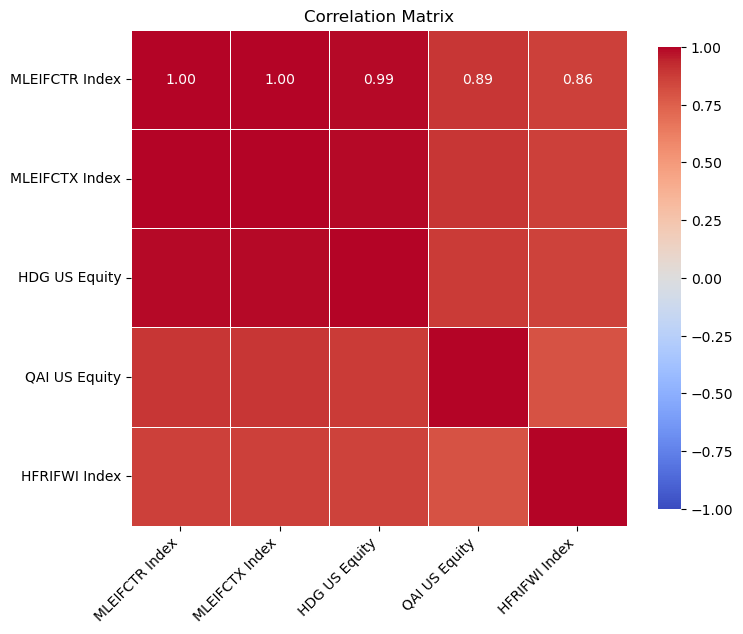

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_corr_matrix(corrs):
    # Pass ax so the plot appears where you want it
    return sns.heatmap(
        corrs,
        annot=True,
        cmap="coolwarm",
        vmin=-1,
        vmax=1,
        linewidths=0.7,
        annot_kws={"size": 10},
        fmt=".2f",
        square=True,
        cbar_kws={"shrink": 0.75},
    )

corr_matrix = rets_hf.corr()

fig, ax = plt.subplots(figsize=(8, 8))
plot_corr_matrix(corr_matrix)  # Pass ax here

ax.set_title("Correlation Matrix")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")

plt.show()


In [12]:
print(corr_matrix)

                MLEIFCTR Index  MLEIFCTX Index  HDG US Equity  QAI US Equity  \
MLEIFCTR Index        1.000000        0.999911       0.987642       0.893522   
MLEIFCTX Index        0.999911        1.000000       0.987456       0.893159   
HDG US Equity         0.987642        0.987456       1.000000       0.879459   
QAI US Equity         0.893522        0.893159       0.879459       1.000000   
HFRIFWI Index         0.863631        0.863052       0.856409       0.802670   

                HFRIFWI Index  
MLEIFCTR Index       0.863631  
MLEIFCTX Index       0.863052  
HDG US Equity        0.856409  
QAI US Equity        0.802670  
HFRIFWI Index        1.000000  


#### Highest: MLEIFCTR and MLEIFCTX with a correlation of 0.999 (~1)
#### Lowest: QAI US Equity and HFRIFWI Index with a correlation of 0.802670

## PROBLEM 6

In [13]:
merill_factors = all_data(sheet_name="merrill_factors")
spy = merill_factors["SPY US Equity"]

regression_metrics = hedge_fund_regression(merill_factors, spy)

regression_metrics

/var/folders/0f/l_wv06ws6k3063l3r6mv6xb80000gn/T/ipykernel_85838/747560374.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inter = res.params[0]
/var/folders/0f/l_wv06ws6k3063l3r6mv6xb80000gn/T/ipykernel_85838/747560374.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inter = res.params[0]
/var/folders/0f/l_wv06ws6k3063l3r6mv6xb80000gn/T/ipykernel_85838/747560374.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  inter = 

,Market Alpha,Market Beta,Treynor Ratio,Information Ratio,R Squared,Tracking Error
SPY US Equity,-1.718785e-18,1.000000,0.139395,-0.623387,1.000000,3.308605e-17
USGG3M Index,9.902772e-04,0.000735,16.297384,2.407954,0.000477,4.935030e-03
EEM US Equity,-7.939072e-03,0.887775,0.032084,-0.735542,0.502459,1.295220e-01
EFA US Equity,-5.198633e-03,0.921311,0.071684,-0.814017,0.756493,7.663673e-02
EUO US Equity,9.571307e-03,-0.405528,-0.143830,0.803822,0.147590,1.428870e-01
IWM US Equity,-4.775043e-03,1.183346,0.090973,-0.611913,0.774406,9.364154e-02


In [14]:
# Define factors (independent variables) and HFRI (dependent variable)
factors = [
    'SPY US Equity', 
    'USGG3M Index', 
    'EEM US Equity', 
    'EFA US Equity', 
    'EUO US Equity', 
    'IWM US Equity'
]
X = merill_factors[factors]  # Factor returns
y = rets_hf['HFRIFWI Index']   # HFRI returns

# Add constant (intercept) to the model
X = sm.add_constant(X)

# Fit unrestricted OLS regression
model = sm.OLS(y, X).fit()

# Print regression summary
print(model.summary())

# Replicate HFRI returns using the regression coefficients
merill_factors['Replicated_HFRI'] = model.predict(X)

                            OLS Regression Results                            
Dep. Variable:          HFRIFWI Index   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     75.02
Date:                Tue, 01 Jul 2025   Prob (F-statistic):           2.91e-42
Time:                        21:40:50   Log-Likelihood:                 516.64
No. Observations:                 154   AIC:                            -1019.
Df Residuals:                     147   BIC:                            -998.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0015      0.001      1.694

In [16]:
model.params.sum()

0.23257503012375116

In [15]:
intercept = model.params['const']
betas = model.params.drop('const')

print("Intercept: ",intercept)
print("Betas:")
print(betas)
print("R Squared: ", model.rsquared)

Intercept:  0.0015245204697642684
Betas:
SPY US Equity    0.025876
USGG3M Index    -0.143954
EEM US Equity    0.086103
EFA US Equity    0.096177
EUO US Equity    0.041600
IWM US Equity    0.125248
dtype: float64
R Squared:  0.7538207884387411


## PROBLEM 7

In [140]:
residuals = y - merill_factors['Replicated_HFRI']
tracking_error = residuals.std()

# Annualize if using daily data (252 trading days)
annualized_te = tracking_error * np.sqrt(252)

print(f"\nTracking Error (σ):")
print(f"- Daily: {tracking_error:.6f}")
print(f"- Annualized: {annualized_te:.6f}")


Tracking Error (σ):
- Daily: 0.008476
- Annualized: 0.134556


OOS-R-Squared: 91.47%


/var/folders/0f/l_wv06ws6k3063l3r6mv6xb80000gn/T/ipykernel_73223/1872622226.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  summary[coeff].append(regr.params[jdx])
/var/folders/0f/l_wv06ws6k3063l3r6mv6xb80000gn/T/ipykernel_73223/1872622226.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = regr.params[0] + (regr.params[1:] @ oos_X)
/var/folders/0f/l_wv06ws6k3063l3r6mv6xb80000gn/T/ipykernel_73223/1872622226.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access 

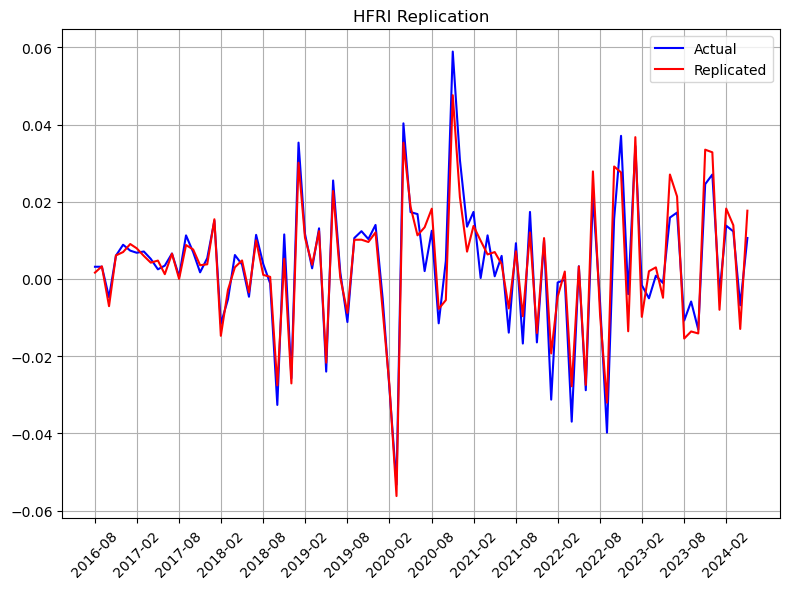

In [141]:
from collections import defaultdict

summary = defaultdict(list)


for idx in range(60, len(rets_hf), 1):
    # Get the data for ML factors and HFRI
    X = rets_ml.iloc[idx - 60 : idx].copy()
    y = rets_hf.iloc[idx - 60 : idx, 0].copy()

    oos_y = rets_hf.iloc[idx, 0]
    oos_X = rets_ml.iloc[idx, :].copy()

    # Calculate the regression coefficients
    regr = sm.OLS(y, sm.add_constant(X), missing="drop").fit()

    for jdx, coeff in enumerate(regr.params.index):
        summary[coeff].append(regr.params[jdx])

    # Get predicted y by multiplying the coefficients by the X values and
    # adding the intercept
    y_pred = regr.params[0] + (regr.params[1:] @ oos_X)

    summary["Replicated"].append(y_pred)
    summary["Actual"].append(oos_y)


summary = pd.DataFrame(summary, index=rets_hf.index[60:])

# Calculate OOS R-Squared
oos_rsquared = (
    1 - (summary["Actual"] - summary["Replicated"]).var() / summary["Actual"].var()
)
print(f"OOS-R-Squared: {oos_rsquared:.2%}")

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(summary.index, summary["Actual"], label="Actual", color="blue")
ax.plot(summary.index, summary["Replicated"], label="Replicated", color="red")
ax.grid(True)
ax.legend()

# Make ticklabels every 6 months and label them as %yyy-%mm
ax.set_xticks(summary.index[::6])
ax.set_xticklabels(
    [f"{i.year}-{i.month:02d}" for i in summary.index[::6]],
    rotation=45,
    horizontalalignment="center",
)

ax.set_title("HFRI Replication")
fig.tight_layout()